# ✅ **Importing Libraries**

In [ ]:
!pip install opendatasets

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import opendatasets as od
import matplotlib.pyplot as plt
import warnings
import ast
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split, cross_val_predict
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from collections import Counter
warnings.filterwarnings('ignore')

# ✅ **Step 1: Downloading the Datasets from Kaggle and IMDb**

In [ ]:
os.environ['KAGGLE_USERNAME'] = 'eecs6414demo'
os.environ['KAGGLE_KEY'] = '80efa062e4f523f6dd92f8433d23441c'

!kaggle datasets download -d anandshaw2001/imdb-data
!unzip imdb-data.zip -d imdb-data

In [ ]:
!gdown https://datasets.imdbws.com/title.ratings.tsv.gz
!gdown https://datasets.imdbws.com/title.basics.tsv.gz
!gdown https://datasets.imdbws.com/title.crew.tsv.gz
!gdown https://datasets.imdbws.com/name.basics.tsv.gz

In [ ]:
kaggle_file_path = ('/content/imdb-data/Imdb Movie Dataset.csv')
kaggle_df = pd.read_csv(kaggle_file_path, usecols=['imdb_id', 'revenue', 'budget', 'original_language',	'overview',	'production_companies',	'production_countries',	'keywords'])
print(kaggle_df.shape)

In [ ]:
title_rating_df = pd.read_csv(('/content/title.ratings.tsv.gz'), sep='\t')
title_basics_df = pd.read_csv(('/content/title.basics.tsv.gz'), sep='\t', usecols=['tconst', 'titleType', 'primaryTitle', 'startYear', 'runtimeMinutes', 'genres'])
title_crew_df = pd.read_csv(('/content/title.crew.tsv.gz'), sep='\t')
name_basics_df = pd.read_csv('/content/name.basics.tsv.gz', sep='\t', usecols=['nconst', 'primaryName'])

# ✅ **Step 2: Preprocessing**

In [ ]:
# Merge title_crew_df with name_basics_df to get director names
title_crew_df = pd.merge(title_crew_df, name_basics_df, left_on='directors', right_on='nconst', how='left')
title_crew_df.rename(columns={'primaryName': 'director_name'}, inplace=True)

# Merge title_crew_df with name_basics_df again to get writer names
title_crew_df = pd.merge(title_crew_df, name_basics_df, left_on='writers', right_on='nconst', how='left')
title_crew_df.rename(columns={'primaryName': 'writer_name'}, inplace=True)

# Replace 'directors' column with 'director_name'
title_crew_df['directors'] = title_crew_df['director_name']

# Replace 'writers' column with 'writer_name'
title_crew_df['writers'] = title_crew_df['writer_name']

# Drop unnecessary columns
title_crew_df.drop(columns=['director_name','writer_name',], inplace=True, errors='ignore')

print(title_crew_df.head())

In [ ]:
# Merge title_rating_df with title_basics_df
imdb_df = pd.merge(title_rating_df, title_basics_df, left_on='tconst', right_on='tconst', how='left')
imdb_df = pd.merge(imdb_df, title_crew_df, left_on='tconst', right_on='tconst', how='left')

In [ ]:
# Delete some variables such as title_rating_df, title_basic_df, title_crew_df, and name_basics_df to free the system RAM.

del title_rating_df
del title_basics_df
del title_crew_df
del name_basics_df

In [ ]:
print(imdb_df.shape)

In [ ]:
imdb_df.head(20)

In [ ]:
imdb_df.info()

In [ ]:
# Number of duplicate movies in kaggle_df
kaggle_df['imdb_id'].value_counts().max()

In [ ]:
# Drop duplicate movies
kaggle_df = kaggle_df.drop_duplicates(subset='imdb_id')

In [ ]:
# How many imdb_ids in kaggle_df exist in imdb_df?
print(kaggle_df['imdb_id'].isin(imdb_df['tconst']).sum())

In [ ]:
# Merge two dataframes
merged_df = pd.merge(imdb_df, kaggle_df, left_on='tconst', right_on='imdb_id', how='left')
print(merged_df.shape)

In [ ]:
del imdb_df
del kaggle_df

In [ ]:
print(merged_df.columns)

In [ ]:
# Drop the columns
merged_df.drop(columns=['imdb_id'], inplace=True)

In [ ]:
print(merged_df.shape)

In [ ]:
merged_df.info()

In [ ]:
# Replace zero with NaN
merged_df = merged_df.replace(0, np.nan)

In [ ]:
# Change datatypes to better handle the data

# Convert 'startYear' to numeric, coercing errors to NaN
merged_df['startYear'] = pd.to_numeric(merged_df['startYear'], errors='coerce').astype('Int64')

# Convert 'runtimeMinutes' to numeric, coercing errors to NaN
merged_df['runtimeMinutes'] = pd.to_numeric(merged_df['runtimeMinutes'], errors='coerce').astype('Int64')

# Convert 'genres_x', 'keywords', 'production_companies', and 'production_countries' to a list of strings
merged_df['genres'] = merged_df['genres'].apply(lambda x: x.split(',') if isinstance(x, str) else [])
merged_df['keywords'] = merged_df['keywords'].apply(lambda x: x.split(',') if isinstance(x, str) else [])
merged_df['production_companies'] = merged_df['production_companies'].apply(lambda x: x.split(',') if isinstance(x, str) else [])
merged_df['production_countries'] = merged_df['production_countries'].apply(lambda x: x.split(',') if isinstance(x, str) else [])

In [ ]:
merged_df.head()

In [ ]:
merged_df['titleType'].value_counts()

In [ ]:
# Drop all samples in merged_df whose 'titleType' is 'tvEpisode', 'video', 'videoGame', 'tvSpecial', tvShort'.

to_drop = ['tvEpisode', 'video', 'videoGame', 'tvSpecial', 'tvShort']
merged_df = merged_df[~merged_df['titleType'].isin(to_drop)]

In [ ]:
merged_df.info()

In [ ]:
merged_df.head(20)

In [ ]:
# New Feature: Profit
merged_df['profit'] = merged_df['revenue'] - merged_df['budget']

## **Weighted Rating**

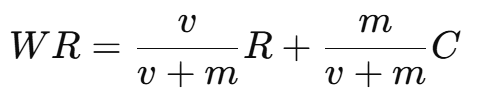

In [ ]:
""" We need to identify top movies while considering both average rating
    and number of votes => A new feature called "Weighted Rating" is needed. """

# WR = Weighted Rating
# R = Average rating of the movie
# v = Number of votes for the movie
# m = Minimum number of votes required (a threshold, e.g., top 90th percentile of vote count)
# C = Mean rating across all movies

# Compute category-specific mean rating (C) for each category
C = merged_df.groupby('titleType')['averageRating'].mean()

# Compute m (minimum number of votes required, e.g., 90th percentile)
m = merged_df['numVotes'].quantile(0.99)

# Function to compute weighted rating
def weighted_rating(row, m=m, C=C):
    v = row['numVotes']
    R = row['averageRating']
    category = row['titleType']
    C_category = C.get(category)
    # If C_category is None, use the overall mean rating instead
    if C_category is None:
        C_category = merged_df['averageRating'].mean()
    return (v / (v + m) * R) + (m / (v + m) * C_category)


# Compute weighted rating for each movie
merged_df['weightedRating'] = merged_df.apply(weighted_rating, axis=1)

In [ ]:
top_movies = merged_df.sort_values(by='weightedRating', ascending=False)
top_movies[['primaryTitle','averageRating','numVotes','startYear','runtimeMinutes','genres','directors','revenue','budget']].head()

In [ ]:
# # OPTIONAL: Save merge_df as a csv file and download it.

# from google.colab import files
# merged_df.to_csv('merged_df.csv', encoding = 'utf-8-sig')
# files.download('merged_df.csv')

# ✅ **Step 3: Data Visualizations**

**1️⃣ Distribution of Movie Ratings**

In [ ]:
# Distribution of Movie Ratings

plt.figure(figsize=(8, 5))
filtered_df = merged_df[merged_df['titleType'] == 'movie']
sns.histplot(filtered_df['averageRating'], bins=np.linspace(1, 10, 19), kde=True)
plt.title("Distribution of Movie Ratings", fontsize=14, fontweight="bold")
plt.xlabel("Average Rating", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.xticks(np.arange(1, 11, 1))
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()

**2️⃣ Runtime vs. Weighted Rating (for top 5000 movies)**

In [ ]:
# Runtime vs. Weighted Rating (for top 5000 movies)

plt.figure(figsize=(8, 5))
filtered_df = merged_df.sort_values('weightedRating', ascending=False)
filtered_df = filtered_df[filtered_df['titleType'].isin(['movie', 'tvMovie'])]
filtered_df_runtime_300 = filtered_df[filtered_df['runtimeMinutes'] < 300]
filtered_df_5000 = filtered_df_runtime_300.head(5000)

sns.scatterplot(x='runtimeMinutes', y='weightedRating', data=filtered_df_5000,
                alpha=0.6, s=60, palette="viridis", edgecolor="black")

# Trendline
sns.regplot(x='runtimeMinutes', y='weightedRating', data=filtered_df_5000, scatter=False, color='red', line_kws={"linewidth": 1.5})

plt.title('Runtime vs. Weighted Rating (for top 5000 movies)', fontsize=13, fontweight='bold')
plt.xlabel('Runtime (minutes)', fontsize=11)
plt.ylabel('Weighted Rating', fontsize=11)
plt.show()

**3️⃣ Pearson Correlation Heatmap**

In [ ]:
# Correlation matrix of numerical features (only for movies and tv movies)

filtered_df = merged_df[merged_df['titleType'].isin(['movie', 'tvMovie'])]
numerical_features = filtered_df[['averageRating', 'weightedRating',
                                  'numVotes', 'startYear',
                                  'runtimeMinutes', 'revenue',
                                  'budget', 'profit']]

correlation_matrix = numerical_features.corr()

plt.figure(figsize=(8, 5))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Pearson Correlation Heatmap', fontsize=13, fontweight='bold')
plt.show()

**4️⃣ Revenue vs. Budget for Top 10 Movies**

In [ ]:
# Revenue vs. Budget for Top 10 Movies

filtered_df = merged_df[merged_df['titleType'].isin(['movie', 'tvMovie'])]
top_10_movies = filtered_df.nlargest(10, 'weightedRating')

movies = top_10_movies['primaryTitle']
revenues = top_10_movies['revenue']
budgets = top_10_movies['budget']

x = np.arange(len(movies))  # X locations for bars
width = 0.4  # Bar width

plt.figure(figsize=(10, 6))

# Plot revenue bars
plt.bar(x - width/2, revenues/1e9, width, label='Revenue', color='dodgerblue')

# Plot budget bars
plt.bar(x + width/2, budgets/1e9, width, label='Budget', color='tomato')

# Formatting
plt.xticks(x, movies, rotation=45, ha='right')
plt.xlabel('Movie Title', fontsize=12)
plt.ylabel('Amount ($B)', fontsize=12)
plt.title('Revenue vs. Budget for Top 10 Movies', fontsize=13, fontweight='bold')
plt.legend()
plt.show()

**5️⃣ Average Rating of Top 10 Most Common Movie Genres**

In [ ]:
# Average Rating of Top 10 Most Common Movie Genres

# Assuming 'genres' column contains lists of genres
genre_counts = {}
for index, row in merged_df.iterrows():
    if row['titleType'] == 'movie':
      for genre in row['genres']:
          if genre in genre_counts:
              genre_counts[genre] += 1
          else:
              genre_counts[genre] = 1

# Sort the genres by count in descending order
sorted_genres = dict(sorted(genre_counts.items(), key=lambda item: item[1], reverse=True))

# Get the top 10 most common genres
top_10_genres = list(sorted_genres.keys())[:10]

# Calculate average rating for each of the top 10 genres
average_ratings = {}
for genre in top_10_genres:
  genre_movies = merged_df[(merged_df['titleType'] == 'movie') & (merged_df['genres'].apply(lambda x: genre in x))]
  average_ratings[genre] = genre_movies['averageRating'].mean()

# Sort the average ratings in descending order
sorted_average_ratings = dict(sorted(average_ratings.items(), key=lambda item: item[1], reverse=True))

# Create the bar plot
plt.figure(figsize=(10, 6))
plt.bar(sorted_average_ratings.keys(), sorted_average_ratings.values(), width=0.6)
plt.xlabel("Genres", fontsize=13)
plt.ylabel("Average Rating", fontsize=13)
plt.title("Average Rating of Top 10 Most Common Movie Genres", fontsize=13, fontweight='bold')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

 **6️⃣ Interactive Plot of Revenue vs. Budget**

In [ ]:
# Interactive Plot of Revenue vs. Budget

fig = px.scatter(merged_df,
                 x='budget',
                 y='revenue',
                 color='averageRating',
                 hover_data=['primaryTitle'],
                 title='Revenue vs. Budget',
                 trendline="ols")

fig.update_xaxes(title_text="Budget", range=[0, 500e6])
fig.update_yaxes(title_text="Revenue")
fig.update_layout(width=800)

fig.show()

 **7️⃣ Distribution of Movie Runtimes for Top 250 Movies**

In [ ]:
# Distribution of Movie Runtimes for Top 250 Movies

filtered_df = merged_df[(merged_df['titleType'] == 'movie')]
filtered_df = filtered_df.nlargest(250, 'weightedRating')

plt.figure(figsize=(10,6))
sns.histplot(filtered_df['runtimeMinutes'], bins=np.linspace(80, 240, 17), kde=True)
plt.title('Distribution of Movie Runtimes for Top 250 Movies',
          fontsize=13, fontweight='bold')
plt.xlabel('Runtime (Minutes)')
plt.ylabel('Number of Movies')
plt.show()

 **8️⃣ Average Movie Rating by Year**

In [ ]:
# Average Movie Rating by Year

ratings_by_year = merged_df.groupby('startYear')['averageRating'].mean()

plt.figure(figsize=(12,6))
ratings_by_year.plot()
plt.title('Average Movie Rating by Year', fontsize=13, fontweight='bold')
plt.xlabel('Year')
plt.ylabel('Average Rating')
plt.xlim(1900) # The lower limit
plt.grid()
plt.show()

 **9️⃣ Average Movie Rating by Decade**

In [ ]:
# Average Movie Rating by Decade

filtered_df = merged_df[merged_df['startYear'].between(1900, 2025)].copy()
filtered_df['decade'] = (filtered_df['startYear'] // 10) * 10  # Group by decade

ratings_by_decade = filtered_df.groupby('decade')['averageRating'].mean().reset_index()

plt.figure(figsize=(12, 6))

sns.lineplot(data=ratings_by_decade, x='decade', y='averageRating', marker='o', linewidth=2)

plt.xlabel('Decade')
plt.ylabel('Average Movie Rating')
plt.title('Average Movie Rating by Decade', fontsize=13, fontweight='bold')
plt.xticks(np.arange(1900, 2030, 10))  # Ensure proper decade labeling
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

 **1️⃣0️⃣ Top 15 Production Companies by Total Profit**

In [ ]:
# Top 15 Production Companies by Total Profit

top_producers = merged_df.copy()
top_producers['production_companies'] = top_producers['production_companies'].apply(lambda x: x if isinstance(x, list) else [x])
top_producers = top_producers.explode('production_companies')
top_producers['production_companies'] = top_producers['production_companies'].str.strip()

# Aggregate profit by production company
top_companies = (top_producers.groupby('production_companies', as_index=False)['profit']
                 .sum()
                 .nlargest(15, 'profit'))  # Get top 15

top_companies['profit'] = top_companies['profit'].apply(lambda x: x / 1e9)  # Convert to billion

plt.figure(figsize=(12, 6))
sns.barplot(data=top_companies, x='profit', y='production_companies')
plt.xlabel('Total Profit ($B)')
plt.ylabel('Production Company')
plt.title('Top 15 Production Companies by Total Profit', fontsize=13, fontweight='bold')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()

 **1️⃣1️⃣ Budget vs. Revenue of Top Companies with Ratings as Bubble Size**

In [ ]:
# Budget vs Revenue of Top Companies with Ratings as Bubble Size

import plotly.graph_objects as go

# Calculate total budget, revenue, and average rating for each company
company_data = []
for company in top_companies['production_companies']:
    company_df = merged_df[merged_df['production_companies'].apply(lambda x: company in x) ]
    total_budget = company_df['budget'].sum()
    total_revenue = company_df['revenue'].sum()
    avg_rating = company_df['averageRating'].mean()
    company_data.append([company, total_budget, total_revenue, avg_rating])

company_df = pd.DataFrame(company_data, columns=['Company', 'Total Budget', 'Total Revenue', 'Average Rating'])
company_df['Average Rating'] = (company_df['Average Rating']-6)*500

fig = go.Figure(data=[go.Scatter(
    x=company_df['Total Budget'],
    y=company_df['Total Revenue'],
    mode='markers+text',
    marker=dict(
        size=company_df['Average Rating'] * 10,
        sizemode='area'
    ),
    text=company_df['Company'],
    textposition="top center"
)])

fig.update_layout(
    title='Bubble Chart of Top Companies',
    xaxis_title='Total Budget',
    yaxis_title='Total Revenue',
    xaxis_range=[0, max(company_df['Total Budget']) * 1.1],  # Set x-axis range to start at 0
    yaxis_range=[0, max(company_df['Total Revenue']) * 1.2],  # Set y-axis range to start at 0
    autosize=False,
    width=2000,  # Adjust width
    height=1000
)

fig.show()

 **1️⃣2️⃣ Evolution of Movie Genres Over Time (Top 10 Genres)**

In [ ]:
# Evolution of Movie Genres Over Time (Top 10 Genres)

# Explode genres column if it contains multiple genres per movie
filtered_df = merged_df[merged_df['startYear'].between(1900, 2019)].copy()
filtered_df = filtered_df.dropna(subset=['genres'])
filtered_df = filtered_df[filtered_df['genres'].apply(lambda x: isinstance(x, list))]  # Ensure genres is a list
filtered_df = filtered_df.explode('genres')

# Remove empty genre entries
filtered_df = filtered_df[filtered_df['genres'].str.strip() != '']

# Filter only for top 10 genres
filtered_df = filtered_df[filtered_df['genres'].isin(top_10_genres)]

# Extract decade
filtered_df['decade'] = (filtered_df['startYear'] // 10) * 10

# Count the number of movies per genre per decade
genre_counts = filtered_df.groupby(['decade', 'genres']).size().reset_index(name='count')

genre_pivot = genre_counts.pivot(index='decade', columns='genres', values='count').fillna(0)

plt.figure(figsize=(12, 6))
genre_pivot.plot(kind='line', marker='o', linewidth=2, figsize=(12, 6), colormap='tab10')
plt.xlabel('Decade')
plt.ylabel('Number of Movies')
plt.title('Evolution of Movie Genres Over Time (Top 10 Genres)', fontsize=13, fontweight='bold')
plt.legend(title='Genres', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(range(1900, 2030, 10))
plt.show()

 **1️⃣3️⃣ Trend of Popular Movie Keywords Over Time**

In [ ]:
# Trend of Popular Movie Keywords Over Time

# Ensure valid years and extract decade
filtered_df = merged_df[merged_df['startYear'].between(1900, 2025)].copy()
filtered_df = filtered_df.dropna(subset=['keywords'])
filtered_df = filtered_df[filtered_df['keywords'].apply(lambda x: isinstance(x, list))]  # Ensure keywords is a list

# Explode keywords to separate rows
filtered_df = filtered_df.explode('keywords')
filtered_df['keywords'] = filtered_df['keywords'].str.strip()

# Remove empty keyword entries
filtered_df = filtered_df[filtered_df['keywords'].str.strip() != '']

# Extract decade
filtered_df['decade'] = (filtered_df['startYear'] // 10) * 10

# Count keyword occurrences per decade
keyword_counts = filtered_df.groupby(['decade', 'keywords']).size().reset_index(name='count')

# Identify top N keywords (e.g., 10 most frequent ones overall)
top_keywords = keyword_counts.groupby('keywords')['count'].sum().nlargest(10).index
keyword_counts = keyword_counts[keyword_counts['keywords'].isin(top_keywords)]

keyword_pivot = keyword_counts.pivot(index='decade', columns='keywords', values='count').fillna(0)

plt.figure(figsize=(12, 6))
keyword_pivot.plot(kind='line', marker='o', linewidth=2, figsize=(12, 6), colormap='tab10')
plt.xlabel('Decade')
plt.ylabel('Keyword Frequency')
plt.title('Trend of Popular Movie Keywords Over Time', fontsize=13, fontweight='bold')
plt.legend(title='Keywords', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(range(1900, 2030, 10))  # Ensure proper decade labeling
plt.show()

 **1️⃣4️⃣ Top 10 Most-Voted Directors Ranked by Average Movie Ratings**

In [ ]:
# Top 10 Most-Voted Directors Ranked by Average Movie Ratings

# Group by director and sum numVotes
director_votes = merged_df.groupby('directors')['numVotes'].sum().reset_index()

# Sort by numVotes in descending order and get the top 10
top_10_directors = director_votes.sort_values('numVotes', ascending=False).head(10)

# Calculate the average rating for each director
director_avg_ratings = {}
for director in top_10_directors['directors']:
    director_movies = merged_df[merged_df['directors'] == director]
    avg_rating = director_movies['averageRating'].mean()
    director_avg_ratings[director] = avg_rating

# Create a DataFrame for plotting
plot_df = pd.DataFrame({'directors': director_avg_ratings.keys(),
                       'averageRating': director_avg_ratings.values()})

# Sort by averageRating in descending order
plot_df = plot_df.sort_values('averageRating', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(plot_df['directors'], plot_df['averageRating'])
plt.xlabel('Average Rating')
plt.ylabel('Director')
plt.title('Top 10 Most-Voted Directors Ranked by Average Movie Ratings', fontsize=13, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

 **1️⃣5️⃣ Global Distribution of Movies (Log Scale by Country)**

In [ ]:
# Global Distribution of Movies (Log Scale by Country)

# Ensure production_countries is a list
def extract_countries(country_list):
    if isinstance(country_list, str):
        try:
            evaluated = ast.literal_eval(country_list)
            return evaluated if isinstance(evaluated, list) else []
        except:
            return []
    return country_list if isinstance(country_list, list) else []

filtered_df['production_countries'] = merged_df['production_countries'].apply(extract_countries)
all_countries = [country for sublist in filtered_df['production_countries'] for country in sublist]
country_counts = Counter(all_countries)
country_df = pd.DataFrame(country_counts.items(), columns=['country', 'movie_count'])
country_df['log_count'] = np.log1p(country_df['movie_count'])

fig = px.choropleth(
    country_df,
    locations='country',
    locationmode='country names',
    color='log_count',
    hover_name='country',
    hover_data={'movie_count': True, 'log_count': True},
    color_continuous_scale='Blues',
    range_color=[0, country_df['log_count'].max()],
    title='Global Distribution of Movies (Log Scale by Country)'
)

fig.update_geos(
    showcoastlines=True,
    coastlinecolor="Black",
    showland=True,
    landcolor="white",
    showocean=True,
    oceancolor="lightblue",
)
fig.update_layout(width=1800, height=900)
fig.show()

# ✅ **Step 4: Predictive Modeling**

**1️⃣ Movie Revenue Prediction (using Random Forest and XGBoost)**

In [ ]:
df = merged_df.copy()

# Filter to movies with valid revenue and budget
df = df[(df['revenue'] > 0) & (df['budget'] > 1_000)]

# Fill useful numeric features with median + create missing flags
numeric_cols = ['runtimeMinutes', 'startYear', 'numVotes']
for col in numeric_cols:
    df[f'{col}_missing'] = df[col].isnull().astype(int)
    df[col].fillna(df[col].median(), inplace=True)

# Fill categorical features with 'Unknown'
cat_cols = ['original_language', 'genres', 'production_companies', 'production_countries']
for col in cat_cols:
    df[col] = df[col].fillna('Unknown')

# Convert 'genres' and 'production_companies' (which are lists) into single values
# Use most common values
all_genres = df['genres'].explode()
top_genres = all_genres.value_counts().nlargest(10).index

def pick_top_genre(genres_list):
    if isinstance(genres_list, list):
        for genre in genres_list:
            if genre in top_genres:
                return genre
        return 'Other'
    else:
        return genres_list if genres_list in top_genres else 'Other'

df['genres'] = df['genres'].apply(pick_top_genre)


all_companies = df['production_companies'].explode()
top_companies = all_companies.value_counts().nlargest(10).index

def pick_top_company(companies_list):
    if isinstance(companies_list, list):
        for company in companies_list:
            if company in top_companies:
                return company
        return 'Other'
    else:
        return companies_list if companies_list in top_companies else 'Other'

df['production_companies'] = df['production_companies'].apply(pick_top_company)

# Drop complex list-based columns
df.drop(columns=['nconst_x', 'nconst_y', 'directors', 'writers', 'overview', 'keywords', 'production_countries'], inplace=True)

# Target variable
df['log_revenue'] = np.log1p(df['revenue'])

# One-hot encode categorical columns
df = pd.get_dummies(df, columns=['genres', 'original_language', 'production_companies'])

# Final features and target
X = df.drop(columns=['tconst', 'titleType', 'primaryTitle', 'revenue', 'profit', 'log_revenue'])
y = df['log_revenue']

print(f"Final cleaned dataset shape: {X.shape}")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

models = {
    "XGBoost": XGBRegressor(n_estimators=200, max_depth=6, random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42)
}

for name, model in models.items():
    model.fit(X_train, y_train)

    # Predict on test set
    y_pred_log = model.predict(X_test)
    y_pred_real = np.expm1(y_pred_log)
    y_test_real = np.expm1(y_test)

    mae = mean_absolute_error(y_test_real, y_pred_real)
    mse = mean_squared_error(y_test_real, y_pred_real)
    r2 = r2_score(y_test_real, y_pred_real)

    y_cv_pred_log = cross_val_predict(model, X, y, cv=5)
    y_cv_pred_real = np.expm1(y_cv_pred_log)
    y_real = np.expm1(y)
    cv_mae = mean_absolute_error(y_real, y_cv_pred_real)

    print()
    print(f"  * {name}:")
    print(f"  - MAE (Real Revenue): ${mae:,.2f}")
    print(f"  - Cross-Validated MAE: ${cv_mae:,.2f}")
    print(f"  - R² Score: {r2:.3f}")

    plt.figure(figsize=(8,6))
    plt.scatter(y_test_real, y_pred_real, alpha=0.4, edgecolors='k')
    plt.plot([1e5, 1e10], [1e5, 1e10], 'r--')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel("True Revenue")
    plt.ylabel("Predicted Revenue")
    plt.title(f"{name}: True vs Predicted Revenue")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

**2️⃣ Movie Rating Prediction (using Random Forest and XGBoost)**

In [ ]:
# Features and target
features = ['numVotes', 'startYear', 'runtimeMinutes', 'budget', 'revenue', 'averageRating']

filtered_df = merged_df[features].copy()

# Drop rows with missing data
filtered_df.dropna(axis=0, how='any', inplace=True)

X = filtered_df[features[:-1]]  # all features except target
y = filtered_df['averageRating']  # target without division by 10

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

models = {
    "XGBoost": XGBRegressor(n_estimators=200, max_depth=6, random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42)
}

for name, model in models.items():
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"  * {name}:")
    print(f"  - MSE: {mse:.2f}")
    print(f"  - MAE: {mae:.2f}")
    print(f"  - R² Score: {r2:.2f}")
    print()

In [ ]:
# # Visualizing the random forest.

# from sklearn.tree import export_graphviz
# import pydotplus
# from IPython.display import Image

# # Extract a single tree from the forest (you can change the index)
# tree_index = 0
# tree = rf_model.estimators_[tree_index]

# # Export the tree to DOT format
# dot_data = export_graphviz(
#     tree,
#     out_file=None,
#     feature_names=X.columns,  # Use the correct feature names
#     filled=True,
#     rounded=True,
#     special_characters=True
# )

# # Convert DOT data to a graph
# graph = pydotplus.graph_from_dot_data(dot_data)

# # Display the graph
# Image(graph.create_png())